# ECE 285 MLIP Assignment 3 - Transfer Learning

## 1 Getting Started

In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 2 Data Loader

### 1

In [3]:
dataset_root_dir = '/datasets/ee285f-public/caltech_ucsd_birds/'

### 2

In [4]:
class BirdsDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})".format(\
                                self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
        self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose(\
        [tv.transforms.Resize(self.image_size),tv.transforms.ToTensor()]) 
        # range [0,1] -> [-1,1]
        x = transform(img)
        x = (x-0.5)*2
        d = self.data.iloc[idx]['class']
        return x, d
    
    def number_of_classes(self):
        return self.data['class'].max() + 1

### 3

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h


<IPython.core.display.Javascript object>


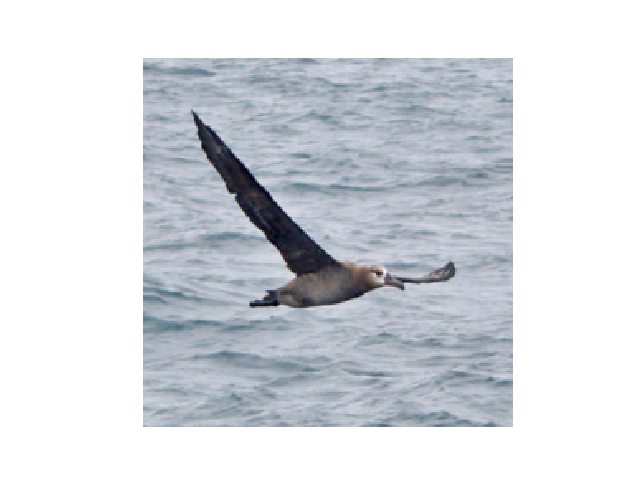

In [7]:
train_set = BirdsDataset(dataset_root_dir)
x,lbl = train_set[10]
myimshow(x)

Fly birdy, fly.

### 4

In [8]:
B = 16
train_loader = td.DataLoader(train_set,batch_size = B, \
                        shuffle = True, pin_memory = True)

The advantage of using pin_memory = True, is that this way the tensors will be copied into CUDA pinned memory before returning them, so as to avoid copying them from CPU to GPU afterwards, which as we know from the previous exercise, is a very slow process.

There are ceiling(num_of_training_images/batch_size) = ceiling(743/16) = 47 mini-batches.

### 5

<IPython.core.display.Javascript object>


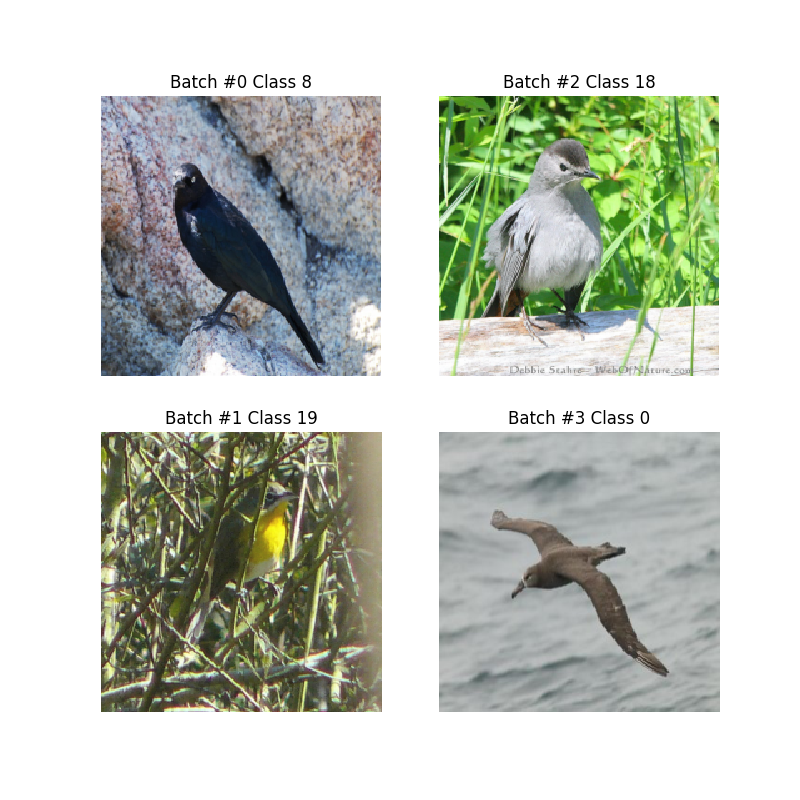

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex='all', sharey='all')

for i_batch, sampled_batch in enumerate(train_loader):
    imgs = sampled_batch[0]
    lbls = sampled_batch[1]
    z=str(lbls[0])
    classn = z.replace('tensor','')
    classn = classn.replace(')','')
    classn = classn.replace('(','')
    ax = axes[i_batch % 2][int(i_batch / 2)]
    ax.set_title('Batch #' + str(i_batch)+' Class ' + classn)
    myimshow(imgs[0],ax)
    # observe 4th batch and stop
    if i_batch == 3:
        break

<IPython.core.display.Javascript object>


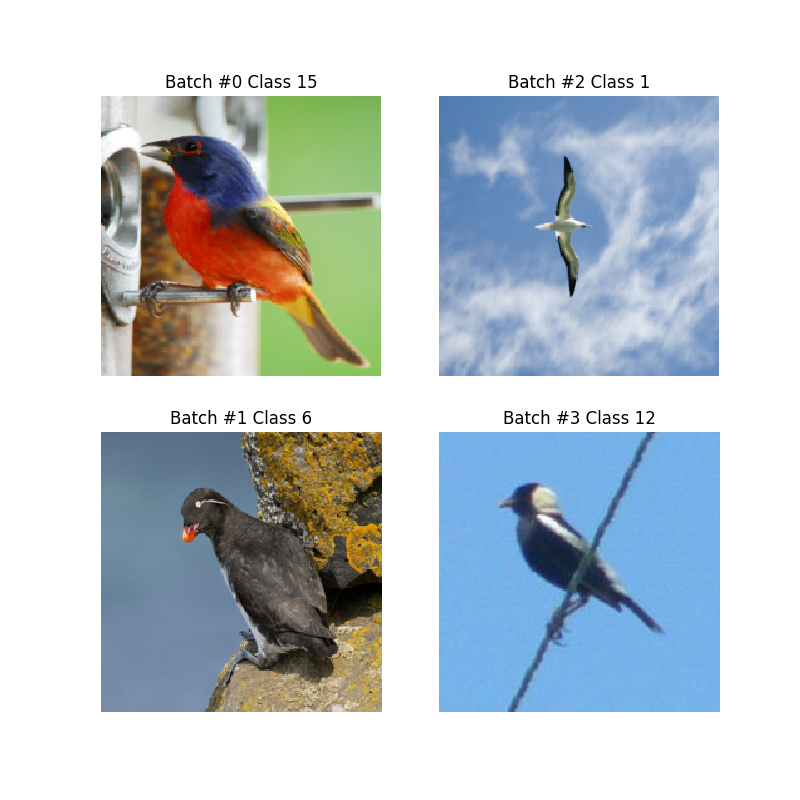

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex='all', sharey='all')

for i_batch, sampled_batch in enumerate(train_loader):
    imgs = sampled_batch[0]
    lbls = sampled_batch[1]
    z=str(lbls[0])
    classn = z.replace('tensor','')
    classn = classn.replace(')','')
    classn = classn.replace('(','')
    ax = axes[i_batch % 2][int(i_batch / 2)]
    ax.set_title('Batch #' + str(i_batch)+' Class ' + classn)
    myimshow(imgs[0],ax)
    # observe 4th batch and stop.
    if i_batch == 3:
        break

Naturally re-evaluating the cell yields a different result, since the batches are shuffled each time.

### 6

In [9]:
val_set = BirdsDataset(dataset_root_dir,mode='val')
B = 16
val_loader = td.DataLoader(train_set,batch_size = B, pin_memory = True)

The point of random shuffling is for the learning process, not to get stuck at a bad local minima with SGD. There is no point of shuffling the validation set, since we are evaluating performance on it, the order of evaluation is meaningless.

# 3 Abstract Neural Network Model

In [10]:
import nntools as nt

### 7

In [11]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

Neural network is still an abstract class, it cannot be instantiated without first implementing its methods. Essentially it is an empty class that doesn't do anything now, so can't instantiate it.

In [12]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
    def criterion(self, y, d):
        return self.cross_entropy(y, d)


# 4 VGG-16 Transfer Learning

### 8

In [35]:
vgg = tv.models.vgg16_bn(pretrained=True)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

### 9

In [36]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        
        self.classifier = vgg.classifier
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.features(x)
        f = x.view(x.size(0), -1)
        y = self.classifier(f)
        return y


### 10

In [37]:
num_classes = train_set.number_of_classes()
net = VGG16Transfer(num_classes)
print(net)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

Notice the output dimension is now 20, as the number of classes to classify.

# 5 Training Experiments and Checkpoints

### 11

In [44]:
class ClassificationStatsManager(nt.StatsManager):

    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100 * self.running_accuracy/self.number_update
        return {'loss': loss, 'accuracy': accuracy}


### 12

When the mode is 'eval', the network is in evaluation mode and some modules behave differently. This is mostly used for the layers with hyper parameters to be learned, like dropout or batch normalization. In evaluation mode, in for example batch normalization layers the hyperparameters $\alpha, \beta$ are tuned continously and are not constant, which is what they are kept in training mode.

### 13

In [39]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager, \
output_dir="birdclass1", perform_validation_during_training=True)

Unsurprisingly, 'config.txt' contains the configuration of the experiment, ie network description, dataset and validation set description, batch size, whether to perform validation and such. Pretty much what's in the section 11 description.

'checkpoint.pth.tar' saves the data to a checkpoint which we can pick up from afterwards, so we don't have to run training from scratch each time.

### 14

In [45]:
lr = 1e-4
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager, \
output_dir="birdclass1", perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

Doesn't work, can't run this same experiment with a different configuation, since we changed the learning rate of the original configuration.

In [54]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager, \
output_dir="birdclass1", perform_validation_during_training=True)

Works fine, since it picks up with the same configuration as the original experiment.

### 15

In [29]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    # loss plot
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],label="evaluation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    # accuracy plot
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],label="evaluation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    fig.canvas.draw()


<IPython.core.display.Javascript object>


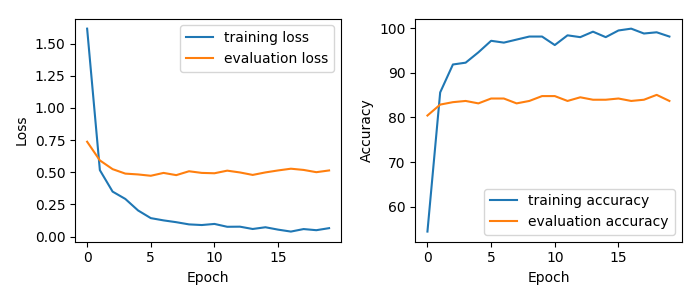

Start/Continue training from epoch 7
Epoch 8 (Time: 20.90s)
Epoch 9 (Time: 20.21s)
Epoch 10 (Time: 20.25s)
Epoch 11 (Time: 23.67s)
Epoch 12 (Time: 24.21s)
Epoch 13 (Time: 24.43s)
Epoch 14 (Time: 24.66s)
Epoch 15 (Time: 23.92s)
Epoch 16 (Time: 24.67s)
Epoch 17 (Time: 23.38s)
Epoch 18 (Time: 24.08s)
Epoch 19 (Time: 24.15s)
Epoch 20 (Time: 23.95s)
Finish training for 20 epochs


In [62]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

Looks similar to what was expected. Notice evaluation loss pretty much reached minimum after ~7 epochs, other epochs may be redundant.

# 6 ResNet18 Transfer Learning

In [23]:
resnet = tv.models.resnet18(pretrained=True)

In [24]:
num_classes = train_set.number_of_classes()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### 16

In [50]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        resnet = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        self.model = resnet
        num_ftrs = resnet.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        
        x= self.model.layer1(x)
        x= self.model.layer2(x)
        x= self.model.layer3(x)
        x= self.model.layer4(x)
        x= self.model.avgpool(x)
        x = x.view(x.size(0),-1)
        
        y = self.model.fc(x)
        return y
    

### 17

In [51]:
lr = 1e-3
net = Resnet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager, \
output_dir="birdclass2", perform_validation_during_training=True)

### 18

<IPython.core.display.Javascript object>


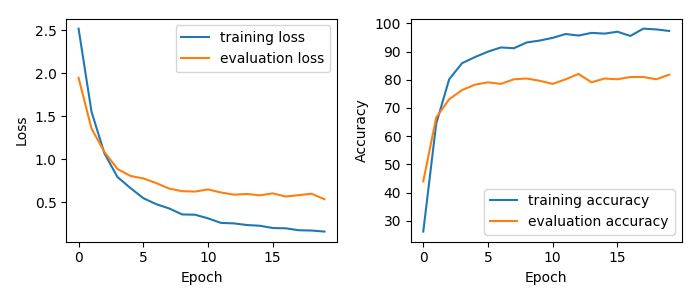

Start/Continue training from epoch 0
Epoch 1 (Time: 141.57s)
Epoch 2 (Time: 34.22s)
Epoch 3 (Time: 37.53s)
Epoch 4 (Time: 22.28s)
Epoch 5 (Time: 24.80s)
Epoch 6 (Time: 31.70s)
Epoch 7 (Time: 23.29s)
Epoch 8 (Time: 82.73s)
Epoch 9 (Time: 244.40s)
Epoch 10 (Time: 79.26s)
Epoch 11 (Time: 119.11s)
Epoch 12 (Time: 113.74s)
Epoch 13 (Time: 113.54s)
Epoch 14 (Time: 56.52s)
Epoch 15 (Time: 55.15s)
Epoch 16 (Time: 109.31s)
Epoch 17 (Time: 38.96s)
Epoch 18 (Time: 49.29s)
Epoch 19 (Time: 55.97s)
Epoch 20 (Time: 22.45s)
Finish training for 20 epochs


In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [41]:
print(exp1.evaluate())

{'loss': 0.5138873241679824, 'accuracy': tensor(83.6957, device='cuda:0')}


~83.7% Accuracy for VGG16, pretty good considering the small training set.

In [52]:
print(exp2.evaluate())

{'loss': 0.5351158296284468, 'accuracy': tensor(81.7935, device='cuda:0')}


~81.8% Accuracy for ResNet18, slightly worse.

Overall, the results look similar to what was expected. Note that ResNet18 performs a bit worse than VGG16, perhaps because it only uses 512 features and not 4096 like VGG16, maybe it is less expressive. In any case, the results are comparable and naturally one could assume that for the deeper resnet versions, the performance would be much better.